In [81]:
import warnings
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from scipy import linalg
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
warnings.filterwarnings("ignore")
import pandas as pd
from matplotlib import pyplot as plt
cpi=pd.read_csv("inflation-of-consumer-prices.csv")
cpi.head()

,Entity,Code,Year,"Inflation, consumer prices (annual %)"
0,Australia,AUS,1960,3.728814
1,Austria,AUT,1960,1.945749
2,Belgium,BEL,1960,0.299467
3,Bolivia,BOL,1960,11.533153
4,Burkina Faso,BFA,1960,7.788162


Text(0.5, 1.0, '')

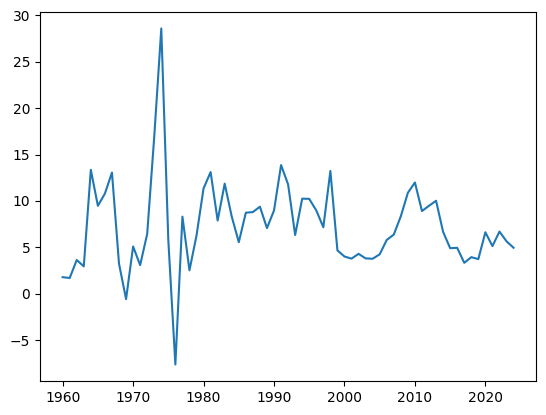

In [82]:

country="India"
data=cpi[cpi["Entity"]==country].sort_values("Year")
cp=data['Inflation, consumer prices (annual %)']
years = pd.to_datetime(data["Year"], format="%Y")
# cp.head()
# cp.tail()
plt.plot(years, cp)
values=pd.DataFrame({"infl":cp,"years":years})
# print(values.iloc[:64])
data.head(28)
plt.title("")




In [83]:
import pandas as pd
import os

df = cpi.copy()     
df = df.drop_duplicates(subset=["Entity", "Year"])

pivot = df.pivot(index="Year", columns="Entity", values="Inflation, consumer prices (annual %)")
corr_matrix = pivot.corr()

os.makedirs("best_correlation", exist_ok=True)

countries = corr_matrix.columns

for country in countries:
    c_series = corr_matrix[country].drop(country)     
    best_match = c_series.idxmax()
    best_value = c_series.max()

    out = pd.DataFrame({
        "Country": [country],
        "Best_Correlated_Country": [best_match],
        "Correlation_Value": [best_value]
    })

    out.to_csv(f"best_correlation/{country}.csv", index=False)


In [84]:
countries=cpi["Entity"].unique()
avg_list=[]
for country in countries:
    country_data = cpi[cpi["Entity"] == country]
    avg_infl = country_data["Inflation, consumer prices (annual %)"].mean()
    avg_list.append({"country": country,"average inflation":avg_infl})
avg_inflation=pd.DataFrame(avg_list)
avg_inflation


,country,average inflation
0,Australia,4.679567
1,Austria,3.363499
2,Belgium,3.498708
3,Bolivia,219.427454
4,Burkina Faso,4.322552
...,...,...
200,Zimbabwe,79.611354
201,Nauru,0.087775
202,New Caledonia,1.130660
203,Tuvalu,0.500581


In [85]:
x=avg_inflation.loc[avg_inflation["country"]=="India","average inflation"].values[0]
print(x)

7.301624906153846


7.301624906153846
4.806831234549597
12.108456140703442


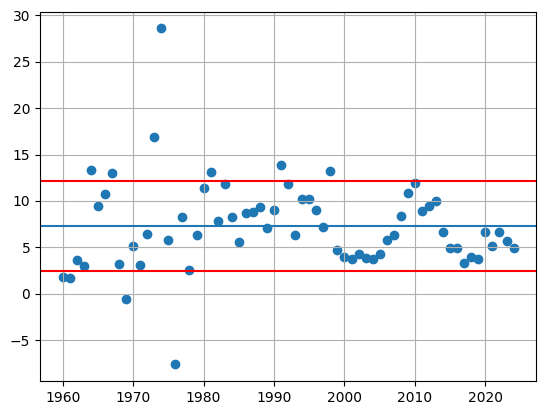

     Entity Code  Year  Inflation, consumer prices (annual %)
23    India  IND  1960                               1.779878
89    India  IND  1961                               1.695213
297   India  IND  1964                              13.355261
543   India  IND  1967                              13.062202
727   India  IND  1969                              -0.584137
1123  India  IND  1973                              16.940817
1227  India  IND  1974                              28.598734
1442  India  IND  1976                              -7.633948
2008  India  IND  1981                              13.112547
3355  India  IND  1991                              13.870246
4502  India  IND  1998                              13.230839


In [86]:
avg=cp.mean()
sd=cp.std()
print(avg)
print(sd)
print(avg+sd)
plt.scatter(years, cp)
plt.axhline(avg)
plt.axhline(sd+avg,color="red")
plt.axhline(avg-sd,color="red")
plt.grid(True)
plt.show()
up=avg+sd
down=avg-sd
outliers=data[(data["Inflation, consumer prices (annual %)"]>up)|(data["Inflation, consumer prices (annual %)"]<down)]
print(outliers)


In [87]:
data_outlier=data.copy()
outlier_rep=((data_outlier["Inflation, consumer prices (annual %)"]>up)|(data_outlier["Inflation, consumer prices (annual %)"]<down))
outlier_years = data_outlier.loc[outlier_rep, "Year"].values
data_outlier.loc[outlier_rep, "Inflation, consumer prices (annual %)"]=np.nan
data_outlier

,Entity,Code,Year,"Inflation, consumer prices (annual %)"
23,India,IND,1960,NaN
89,India,IND,1961,NaN
157,India,IND,1962,3.632215
227,India,IND,1963,2.946161
297,India,IND,1964,NaN
...,...,...,...,...
8736,India,IND,2020,6.623437
8925,India,IND,2021,5.131407
9114,India,IND,2022,6.699034
9302,India,IND,2023,5.649143


In [88]:

y=data_outlier["Inflation, consumer prices (annual %)"].values
indices_known=np.where(~np.isnan(y))[0]
indices_unknown=np.where(np.isnan(y))[0]
I=np.eye(len(y))
S1 = I[:, indices_known]
S2 = I[:, indices_unknown]
x_known = y[indices_known].reshape(-1, 1)
n = len(y)
D = np.zeros((n - 2, n))
for i in range(n - 2):
    D[i, i] = 1
    D[i, i + 1] = -2
    D[i, i + 2] = 1
A = np.dot(D, S2)
b_vec = -np.dot(D, np.dot(S1, x_known))
vhat = linalg.lstsq(A, b_vec)[0]
y_filled = y.copy()
y_filled[indices_unknown] = vhat.flatten()


In [89]:
clean_data=data.copy()
clean_data["Inflation, consumer prices (annual %)"]=y_filled
clean_data

,Entity,Code,Year,"Inflation, consumer prices (annual %)"
23,India,IND,1960,5.004322
89,India,IND,1961,4.318269
157,India,IND,1962,3.632215
227,India,IND,1963,2.946161
297,India,IND,1964,5.874936
...,...,...,...,...
8736,India,IND,2020,6.623437
8925,India,IND,2021,5.131407
9114,India,IND,2022,6.699034
9302,India,IND,2023,5.649143


In [90]:
# print(clean_data.iloc[:,3].mean())
# print(clean_data.iloc[:,3].std())

# print(clean_data.iloc[:,3].mean()+clean_data.iloc[:,3].std())
# print(clean_data.iloc[:,3].mean()-clean_data.iloc[:,3].std())
# plt.scatter(years,clean_data.iloc[:,3])
# plt.axhline(clean_data.iloc[:,3].mean())
# plt.axhline(clean_data.iloc[:,3].mean()+clean_data.iloc[:,3].std(),color="red")
# plt.axhline(clean_data.iloc[:,3].mean()-clean_data.iloc[:,3].std(),color="red")
# plt.grid(True)
# plt.show()
# up=clean_data.iloc[:,3].mean()+clean_data.iloc[:,3].std()
# down=clean_data.iloc[:,3].mean()-clean_data.iloc[:,3].std()
# outliers=clean_data[(clean_data["Inflation, consumer prices (annual %)"]>up)|(clean_data["Inflation, consumer prices (annual %)"]<down)]
# print(outliers)



In [91]:
clean_data.iloc[:,3]

23      5.004322
89      4.318269
157     3.632215
227     2.946161
297     5.874936
          ...   
8736    6.623437
8925    5.131407
9114    6.699034
9302    5.649143
9485    4.953035
Name: Inflation, consumer prices (annual %), Length: 65, dtype: float64

In [ ]:
from statsmodels.tsa.stattools import adfuller

diffrence=clean_data.iloc[:, 3].diff().dropna()
result1=adfuller(diffrence)
print(result1[0])
print(result1[1])
 

if result1[1]<0.05:
    print("ok")
else:
    print("not ok")

-5.3051337383864885
5.343157742930871e-06
ok


<function plot_pacf at 0x00000255497D8FE0>
-------------


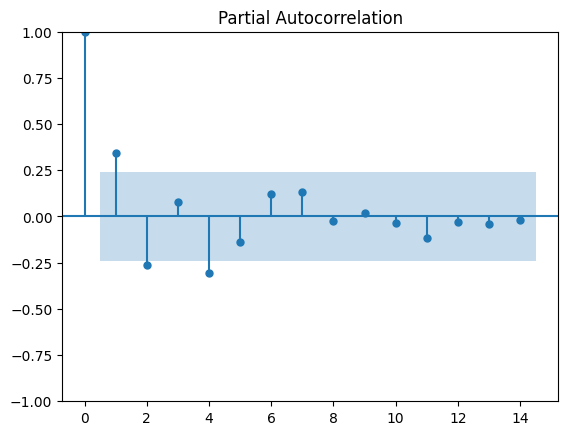

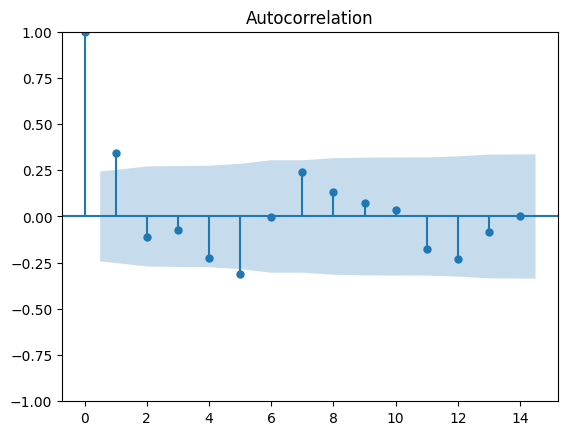

In [ ]:

plot_pacf(clean_data.iloc[:, 3].diff().dropna(),lags=14)
plot_acf(clean_data.iloc[:, 3].diff().dropna(),lags=14)
print(plot_pacf)
print("-------------")
plt.show(plot_acf)





p=1 q=1 d=0

usa (2,1,2) 

In [ ]:
clean_data["Year"]=pd.to_datetime(clean_data["Year"],format="%Y")
clean_data


,Entity,Code,Year,"Inflation, consumer prices (annual %)"
23,India,IND,1960-01-01,1.779878
89,India,IND,1961-01-01,1.695213
157,India,IND,1962-01-01,3.632215
227,India,IND,1963-01-01,2.946161
297,India,IND,1964-01-01,13.355261
...,...,...,...,...
8736,India,IND,2020-01-01,6.623437
8925,India,IND,2021-01-01,5.131407
9114,India,IND,2022-01-01,6.699034
9302,India,IND,2023-01-01,5.649143


In [ ]:
y=clean_data.set_index("Year")["Inflation, consumer prices (annual %)"]

p=[2,5]
d=[1]
q=[5]
tscv=TimeSeriesSplit(n_splits=4)
results = []
for pv in p:
    for dv in d:
        for qv in q:
            temp=[]
            print(f"seqeunce({pv},{dv},{qv})")
            for fold,(train_idx, test_idx) in enumerate(tscv.split(y)):
                y_train, y_test = y.iloc[train_idx],y.iloc[test_idx]
                model=ARIMA(y_train, order=(pv, dv, qv))
                result=model.fit()
                start=len(y_train)
                end=start+len(y_test)-1
                preds=result.predict(start=start,end=end,typ="levels")
                train_rmse=rmse(y_train,result.fittedvalues)
                test_rmse=rmse(y_test,preds)
                temp.append((train_rmse,test_rmse))
            temp=np.array(temp)
            mean_train=np.mean(temp[:,0])
            mean_test=np.mean(temp[:,1])
            results.append((pv, dv, qv,mean_train, mean_test))

cv_results=pd.DataFrame(results,columns=["p","d","q","mean train","mean test rmse"])
print(cv_results)
best_model=cv_results.loc[cv_results["mean test rmse"].idxmin()]
print(f"best({int(best_model.p)},{int(best_model.d)},{int(best_model.q)})"f"Test RMSE={best_model['mean test rmse']:.2f}")


seqeunce(1,0,1)
seqeunce(1,0,5)
seqeunce(2,0,1)
seqeunce(2,0,5)
seqeunce(4,0,1)
seqeunce(4,0,5)
   p  d  q  mean train  mean test rmse
0  1  0  1    4.929732        4.510737
1  1  0  5    4.360867        4.545714
2  2  0  1    4.744408        4.561320
3  2  0  5    4.084905        4.996272
4  4  0  1    4.017160        4.400706
5  4  0  5    3.879246        5.047466
best(4,0,1)Test RMSE=4.40


In [96]:
y

Year
1960-01-01     1.779878
1961-01-01     1.695213
1962-01-01     3.632215
1963-01-01     2.946161
1964-01-01    13.355261
                ...    
2020-01-01     6.623437
2021-01-01     5.131407
2022-01-01     6.699034
2023-01-01     5.649143
2024-01-01     4.953035
Name: Inflation, consumer prices (annual %), Length: 65, dtype: float64

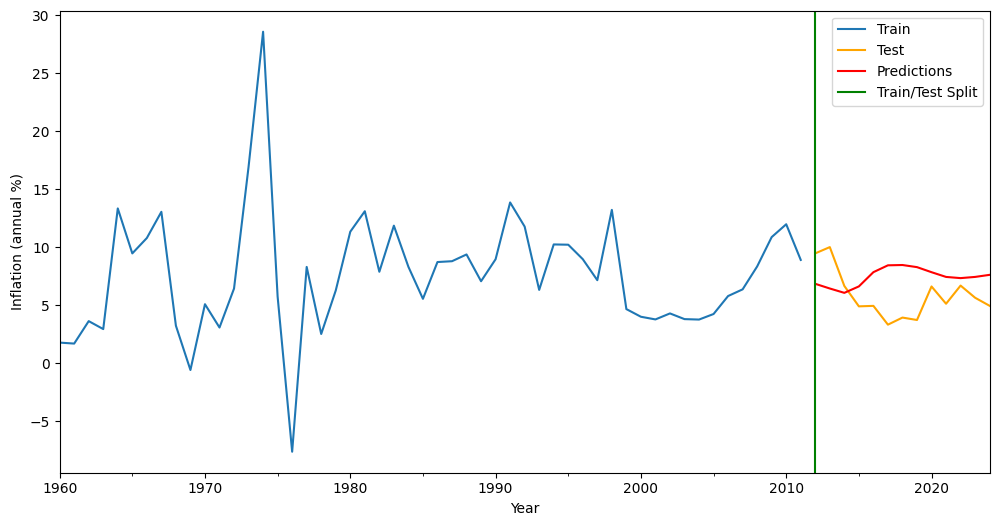

               Actual  Predicted  Difference
2012-01-01   9.478997   6.850788    2.628209
2013-01-01  10.017879   6.446988    3.570891
2014-01-01   6.665657   6.071482    0.594174
2015-01-01   4.906973   6.627185   -1.720212
2016-01-01   4.948216   7.856397   -2.908181
2017-01-01   3.328173   8.446637   -5.118464
2018-01-01   3.938827   8.473234   -4.534408
2019-01-01   3.729506   8.290226   -4.560721
2020-01-01   6.623437   7.853572   -1.230135
2021-01-01   5.131407   7.444890   -2.313483
2022-01-01   6.699034   7.342991   -0.643957
2023-01-01   5.649143   7.446052   -1.796909
2024-01-01   4.953035   7.624962   -2.671927


In [ ]:
plt.figure(figsize=(12,6))
X=clean_data[["Year"]]
y=clean_data.iloc[:,3]
y.index=clean_data["Year"]
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.80,shuffle=False)
model=ARIMA(y_train,order=(1,3,3))
result=model.fit()
start=len(y_train)
end=len(y_train)+len(y_test)-1
predictions=result.predict(start=start,end=end,typ="levels")
predictions.index=X_test["Year"].values
#plt.figure(figsize=(10,5))
y_train.plot(label="Train")
y_test.plot(label="Test", color="orange")
predictions.plot(label="Predictions", color="red")
plt.axvline(y_test.index[0], color='green',label="Train/Test Split")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Inflation (annual %)")
plt.show()
comparison = pd.DataFrame({"Actual": y_test,"Predicted": predictions,"Difference": y_test -predictions})
print(comparison)


In [115]:
train_rmse=rmse(y_train, result.fittedvalues)
test_rmse=rmse(y_test, predictions)
print(f"Train rmse:{train_rmse}")
print(f"Test rmse:{test_rmse}")


Train rmse:4.367256456641613
Test rmse:2.9953338472454334


In [118]:
if test_rmse <= train_rmse * 1.5:
    print("good")
elif test_rmse > train_rmse * 2:
    print("ok ok")
else:
    print("not ok")

good


In [100]:

model=ARIMA(clean_data.iloc[:,3],order=(2,0,1))
res=model.fit()
print(res.summary())

                                         SARIMAX Results                                         
Dep. Variable:     Inflation, consumer prices (annual %)   No. Observations:                   65
Model:                                    ARIMA(2, 0, 1)   Log Likelihood                -137.421
Date:                                   Sun, 16 Nov 2025   AIC                            284.843
Time:                                           10:56:23   BIC                            295.715
Sample:                                                0   HQIC                           289.132
                                                    - 65                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7315      0.637     10.566      0.000    

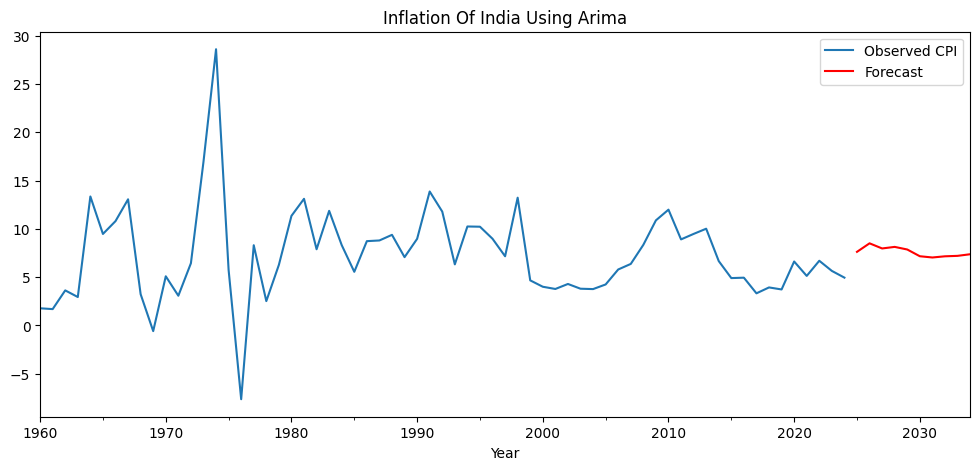

In [119]:
model=ARIMA(y,order=(4,0,1))
result=model.fit()
forecast=result.predict(start=len(y),end=len(y)+10-1)
last_year=y.index[-1].year
forecast.index=pd.date_range(start=str(last_year+1),periods=10,freq="Y")
plt.figure(figsize=(12,5))
y.plot(label="Observed CPI")
forecast.plot(label="Forecast", color="red")
plt.title("Inflation Of India Using Arima")
plt.legend()
plt.show()

In [122]:
forecast_df=pd.DataFrame({"Year":forecast.index,"Forecasted Inflation":forecast.values})
print(forecast_df)

        Year  Forecasted Inflation
0 2025-12-31              7.623969
1 2026-12-31              8.504810
2 2027-12-31              7.973608
3 2028-12-31              8.135761
4 2029-12-31              7.865121
5 2030-12-31              7.167855
6 2031-12-31              7.038997
7 2032-12-31              7.161193
8 2033-12-31              7.207275
9 2034-12-31              7.373914


In [103]:
# import warnings
# from statsmodels.tsa.arima.model import ARIMA
# warnings.filterwarnings("ignore")
# from sklearn.model_selection import train_test_split
# from statsmodels.tools.eval_measures import rmse
# import numpy as np
# data["Year"]=pd.to_datetime(data["Year"], format="%Y")
# X=data[["Year"]]  
# y=data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()
# p=[1,2,4]
# d=[0]
# q=[1,5]

# results=[]
# train_test_sizes=[[0.60,0.1],[0.70,0.1],[ 0.80,0.1],[0.90,0.1]]


# for pv in p:
#     for dv in d:
#         for qv in q:
#             temp=[] 
#             print(f"order({pv},{dv},{qv})")
#             print()
#             for size1,size2 in train_test_sizes:
#                 print(f"ttsize({size1},{size2})")
                
#                 X_train,X_test,y_train,y_test=train_test_split(X, y,train_size=size1,test_size=size2,shuffle=False)
#                 model=ARIMA(y_train,order=(pv,dv,qv))   
#                 result=model.fit()
#                 start=len(y_train)
#                 end=len(y_train)+len(y_test)-1
#                 predictions = result.predict(start=start, end=end, typ="levels")
#                 predictions.index = X_test["Year"].values
#                 fitted_vals=result.fittedvalues
#                 fitted_vals.index=y_train.index

#                 trainr=rmse(y_train,fitted_vals)
#                 testr=rmse(y_test,predictions)
#                 diff=trainr-testr
#                 results.append((pv,dv,qv,trainr,testr,diff))
#                 temp.append((trainr,testr))
#                 diff=trainr-testr
#                 print("rms train",trainr)
#                 print("rms test",testr)
#                 print('diff',diff)
#                 print()
                
#             temp_arr=np.array(temp)
#             mtrain=np.mean(temp_arr[:,0])
#             stdtrain=np.std(temp_arr[:,0])
#             mtest=np.mean(temp_arr[:,1])
#             stdtest=np.std(temp_arr[:,1])
#             print(f"mean trainr{mtrain:.2f},std{stdtrain:.2f}")
#             print(f" mean testr{mtest:.2f},std{stdtest:.2f}")
#             print("-"*50)



In [104]:
# import warnings
# warnings.filterwarnings("ignore")
# from sklearn.model_selection import train_test_split
# from statsmodels.tools.eval_measures import rmse
# import numpy as np
# data["Year"]=pd.to_datetime(data["Year"], format="%Y")
# X=data[["Year"]]  
# y=data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()
# p=[2]
# d=[1]
# q=[2]

# results=[]
# train_test_sizes=[[0.60,0.1],[0.70,0.1],[ 0.80,0.1],[0.90,0.1]]


# for pv in p:
#     for dv in d:
#         for qv in q:
#             temp=[] 
#             print(f"order({pv},{dv},{qv})")
#             print()
#             for size1,size2 in train_test_sizes:
#                 print(f"ttsize({size1},{size2})")
                
#                 X_train,X_test,y_train,y_test=train_test_split(X, y,train_size=size1,test_size=size2,shuffle=False)
#                 model=ARIMA(y_train,order=(pv,dv,qv))   
#                 result=model.fit()
#                 start=len(y_train)
#                 end=len(y_train)+len(y_test)-1
#                 predictions = result.predict(start=start, end=end, typ="levels")
#                 predictions.index = X_test["Year"].values
#                 fitted_vals=result.fittedvalues
#                 fitted_vals.index=y_train.index

#                 trainr=rmse(y_train,fitted_vals)
#                 testr=rmse(y_test,predictions)
#                 diff=trainr-testr
#                 results.append((pv,dv,qv,trainr,testr,diff))
#                 temp.append((trainr,testr))
#                 diff=trainr-testr
#                 print("rms train",trainr)
#                 print("rms test",testr)
#                 print('diff',diff)
#                 print()
                
#             temp_arr=np.array(temp)
#             mtrain=np.mean(temp_arr[:,0])
#             stdtrain=np.std(temp_arr[:,0])
#             mtest=np.mean(temp_arr[:,1])
#             stdtest=np.std(temp_arr[:,1])
#             print(f"mean trainr{mtrain:.2f},std{stdtrain:.2f}")
#             print(f" mean testr{mtest:.2f},std{stdtest:.2f}")
#             print("-"*50)



new

In [105]:


any_outlier=clean_data[(clean_data["Inflation, consumer prices (annual %)"]>up)|(clean_data["Inflation, consumer prices (annual %)"]<down)]
print(any_outlier)

Empty DataFrame
Columns: [Entity, Code, Year, Inflation, consumer prices (annual %)]
Index: []


In [106]:
data_outlier=clean_data.copy()
outlier_rep=((data_outlier["Inflation, consumer prices (annual %)"]>up)|(data_outlier["Inflation, consumer prices (annual %)"]<down))
outlier_years = data_outlier.loc[outlier_rep, "Year"].values
data_outlier.loc[outlier_rep, "Inflation, consumer prices (annual %)"]=np.nan
data_outlier

y=data_outlier["Inflation, consumer prices (annual %)"].values
indices_known=np.where(~np.isnan(y))[0]
indices_unknown=np.where(np.isnan(y))[0]
I=np.eye(len(y))
S1 = I[:, indices_known]
S2 = I[:, indices_unknown]
x_known = y[indices_known].reshape(-1, 1)
n = len(y)
D = np.zeros((n -2, n))
for i in range(n - 2):
    D[i, i] = 1
    D[i, i + 1] = -2
    D[i, i + 2] = 1
A = np.dot(D, S2)
b_vec = -np.dot(D, np.dot(S1, x_known))
vhat = linalg.lstsq(A, b_vec)[0]
y_filled = y.copy()
y_filled[indices_unknown] = vhat.flatten()

In [107]:
data_outlier

,Entity,Code,Year,"Inflation, consumer prices (annual %)"
23,India,IND,1960,5.004322
89,India,IND,1961,4.318269
157,India,IND,1962,3.632215
227,India,IND,1963,2.946161
297,India,IND,1964,5.874936
...,...,...,...,...
8736,India,IND,2020,6.623437
8925,India,IND,2021,5.131407
9114,India,IND,2022,6.699034
9302,India,IND,2023,5.649143


In [108]:
usa_re=clean_data.copy()
usa_re["Inflation, consumer prices (annual %)"]=y_filled
usa_re

,Entity,Code,Year,"Inflation, consumer prices (annual %)"
23,India,IND,1960,5.004322
89,India,IND,1961,4.318269
157,India,IND,1962,3.632215
227,India,IND,1963,2.946161
297,India,IND,1964,5.874936
...,...,...,...,...
8736,India,IND,2020,6.623437
8925,India,IND,2021,5.131407
9114,India,IND,2022,6.699034
9302,India,IND,2023,5.649143


In [109]:
usa_re

,Entity,Code,Year,"Inflation, consumer prices (annual %)"
23,India,IND,1960,5.004322
89,India,IND,1961,4.318269
157,India,IND,1962,3.632215
227,India,IND,1963,2.946161
297,India,IND,1964,5.874936
...,...,...,...,...
8736,India,IND,2020,6.623437
8925,India,IND,2021,5.131407
9114,India,IND,2022,6.699034
9302,India,IND,2023,5.649143
